In [1]:
import bioframe as bf
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/mpra/merged"

In [3]:
models = [
    #"CADD.RawScore",
    "phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_models = models[-1:] + [
    "Enformer",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    #"LongSafari/hyenadna-large-1m-seqlen-hf",
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = load_dataset(f"../../{dataset_path}", split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,GPN-MSA
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-4.609375
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-5.617188
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-6.937500
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-5.500000
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-5.226562
...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-6.468750
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-5.238281
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-5.902344
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-4.339844


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,GPN-MSA,...,Enformer_feature_5303,Enformer_feature_5304,Enformer_feature_5305,Enformer_feature_5306,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-4.609375,...,-9.037437,-17.332834,-16.247840,-10.711237,-28.746716,-6.826314,-5.285005,-9.726204,-8.162698,-3.253439
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-5.617188,...,-31.222970,-27.449953,-31.167246,-26.528149,-36.764110,-8.728548,-20.746275,-16.366160,-4.191354,-8.425929
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-6.937500,...,-36.579110,-11.331200,-10.459282,-1.218783,-35.258472,-12.894052,-8.983830,-21.300335,-2.001013,-13.026719
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-5.500000,...,-57.999477,-45.177856,-47.684734,-40.981995,-8.494064,-8.513465,-16.347460,-10.711194,-15.318788,-52.683320
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-5.226562,...,-44.427612,-34.068500,-32.023544,-26.613686,-5.065323,-8.236230,-17.490995,-8.479648,-18.497257,-53.239840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-6.468750,...,-4.396457,-2.070612,-1.054204,-4.017059,-0.872473,-12.162338,-5.911765,-23.028929,-10.885457,-12.385613
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-5.238281,...,-1.329435,-1.391802,-0.395280,-2.112898,-4.289438,-12.031926,-0.177164,-8.459882,-2.846754,-9.391858
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-5.902344,...,-2.650755,-0.867357,-0.317215,-3.525281,-5.291180,-12.704936,-1.505264,-13.749182,-4.466585,-18.746244
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-4.339844,...,-6.245222,-0.017363,-0.171039,-3.500834,-10.773319,-7.446294,-0.643606,-1.593197,-7.914445,-18.359210


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [6]:
V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
models.append("Enformer_l2")

In [7]:
# optional
#V = V[V.p_value < 1e-5].copy()
#V.shape

In [8]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,GPN-MSA,...,Enformer_feature_5304,Enformer_feature_5305,Enformer_feature_5306,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312,Enformer_l2
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-4.609375,...,-17.332834,-16.247840,-10.711237,-28.746716,-6.826314,-5.285005,-9.726204,-8.162698,-3.253439,-525.938642
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-5.617188,...,-27.449953,-31.167246,-26.528149,-36.764110,-8.728548,-20.746275,-16.366160,-4.191354,-8.425929,-973.519073
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-6.937500,...,-11.331200,-10.459282,-1.218783,-35.258472,-12.894052,-8.983830,-21.300335,-2.001013,-13.026719,-694.736651
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-5.500000,...,-45.177856,-47.684734,-40.981995,-8.494064,-8.513465,-16.347460,-10.711194,-15.318788,-52.683320,-1472.312931
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-5.226562,...,-34.068500,-32.023544,-26.613686,-5.065323,-8.236230,-17.490995,-8.479648,-18.497257,-53.239840,-1450.567642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-6.468750,...,-2.070612,-1.054204,-4.017059,-0.872473,-12.162338,-5.911765,-23.028929,-10.885457,-12.385613,-11773.456256
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-5.238281,...,-1.391802,-0.395280,-2.112898,-4.289438,-12.031926,-0.177164,-8.459882,-2.846754,-9.391858,-5605.575908
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-5.902344,...,-0.867357,-0.317215,-3.525281,-5.291180,-12.704936,-1.505264,-13.749182,-4.466585,-18.746244,-9448.819182
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-4.339844,...,-0.017363,-0.171039,-3.500834,-10.773319,-7.446294,-0.643606,-1.593197,-7.914445,-18.359210,-3372.241451


In [9]:
V["label"] = V.effect_size.abs()

In [10]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, spearmanr(V_train.label, -V_train[f])[0]]
        for f in features
    ], columns=["Model", "Spearman"]).sort_values("Spearman", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', RidgeCV(
            alphas=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    #print(clf.named_steps["linear"].alpha_)
    return -clf.predict(V_test[features])

supervised_models = [
    #("Best inner product", train_predict_best_inner_product),
    #("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    #("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    #("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    #("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]


for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))


supervised_models.append((
    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
))    
    

def train_predict_lr_split(V, model_name, model):
    all_pos = np.unique(V.pos)  # sorted
    splits = [all_pos[::2], all_pos[1::2]]
    for split in splits:
        mask_train = V.pos.isin(split)
        mask_test = ~mask_train
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])
    return V[model_name].values
        

for element in tqdm(V.element.unique()):
    V_e = V[V.element==element]
    for m, model in supervised_models:
        V.loc[V.element==element, m] = train_predict_lr_split(V_e, m, model)
        if m not in models: models.append(m)
V

100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


,chrom,pos,ref,alt,element,effect_size,p_value,barcodes,phyloP-100-vertebrates,GPN-MSA,...,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312,Enformer_l2,label,GPN-MSA - LR(inner products),Enformer - LR(inner products),GPN-MSA + Enformer - LR(inner products+abs(delta features))
0,1,109274652,G,A,SORT1,-0.061260,0.096538,139,-1.605,-4.609375,...,-6.826314,-5.285005,-9.726204,-8.162698,-3.253439,-525.938642,0.061260,0.024374,-0.120726,-0.161808
1,1,109274652,G,C,SORT1,0.044592,0.534397,36,-1.605,-5.617188,...,-8.728548,-20.746275,-16.366160,-4.191354,-8.425929,-973.519073,0.044592,-0.071821,-0.050650,-0.112666
2,1,109274652,G,T,SORT1,0.008868,0.809138,138,-1.605,-6.937500,...,-12.894052,-8.983830,-21.300335,-2.001013,-13.026719,-694.736651,0.008868,-0.070805,-0.094862,-0.131973
3,1,109274653,A,C,SORT1,0.121466,0.192809,21,-1.873,-5.500000,...,-8.513465,-16.347460,-10.711194,-15.318788,-52.683320,-1472.312931,0.121466,-0.111095,-0.041179,-0.061170
4,1,109274653,A,G,SORT1,0.064338,0.193495,79,-1.873,-5.226562,...,-8.236230,-17.490995,-8.479648,-18.497257,-53.239840,-1450.567642,0.064338,-0.052988,-0.045287,-0.059929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,X,139530763,T,A,F9,-0.173105,0.006950,169,-2.926,-6.468750,...,-12.162338,-5.911765,-23.028929,-10.885457,-12.385613,-11773.456256,0.173105,-0.071740,-0.233554,-0.232431
20488,X,139530763,T,C,F9,0.009252,0.908126,108,-2.926,-5.238281,...,-12.031926,-0.177164,-8.459882,-2.846754,-9.391858,-5605.575908,0.009252,-0.097838,-0.104513,-0.091231
20489,X,139530763,T,G,F9,0.094613,0.279509,91,-2.926,-5.902344,...,-12.704936,-1.505264,-13.749182,-4.466585,-18.746244,-9448.819182,0.094613,-0.108562,-0.103902,-0.093954
20490,X,139530764,T,C,F9,0.175202,0.027533,110,-0.915,-4.339844,...,-7.446294,-0.643606,-1.593197,-7.914445,-18.359210,-3372.241451,0.175202,-0.100161,-0.199967,-0.222950


## Testing

In [11]:
rows = []
for element in tqdm(V.element.unique()):
    V_e = V[V.element==element]
    y = V_e.label
    for m in models:
        x = -V_e[m]
        rows.append([
            element,
            m,
            pearsonr(x, y)[0],
            spearmanr(x, y)[0],
        ])
results = pd.DataFrame(rows, columns=["Element", "Model", "Pearson", "Spearman"])
results

100%|██████████| 16/16 [00:00<00:00, 44.25it/s]


,Element,Model,Pearson,Spearman
0,SORT1,phyloP-100-vertebrates,-0.135189,-0.096452
1,SORT1,GPN-MSA,-0.162739,-0.065428
2,SORT1,Enformer_l2,0.539906,0.558468
3,SORT1,GPN-MSA - LR(inner products),0.656538,0.503233
4,SORT1,Enformer - LR(inner products),0.734938,0.580356
...,...,...,...,...
91,F9,GPN-MSA,-0.080065,-0.025825
92,F9,Enformer_l2,0.044304,0.198014
93,F9,GPN-MSA - LR(inner products),0.509873,0.265519
94,F9,Enformer - LR(inner products),0.617404,0.376270


In [12]:
results.groupby("Model").Pearson.mean().sort_values(ascending=False)

Model
GPN-MSA + Enformer - LR(inner products+abs(delta features))    0.627828
Enformer - LR(inner products)                                  0.607193
GPN-MSA - LR(inner products)                                   0.499863
Enformer_l2                                                    0.420531
GPN-MSA                                                        0.196133
phyloP-100-vertebrates                                         0.164211
Name: Pearson, dtype: float64

In [13]:
results.groupby("Model").Spearman.mean().sort_values(ascending=False)

Model
GPN-MSA + Enformer - LR(inner products+abs(delta features))    0.426489
Enformer - LR(inner products)                                  0.389855
GPN-MSA - LR(inner products)                                   0.353988
Enformer_l2                                                    0.331456
GPN-MSA                                                        0.172277
phyloP-100-vertebrates                                         0.131841
Name: Spearman, dtype: float64

<Axes: xlabel='Spearman', ylabel='Model'>

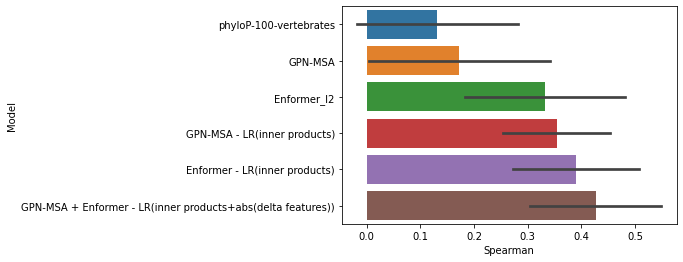

In [18]:
sns.barplot(data=results, y="Model", x="Spearman", errorbar="sd")

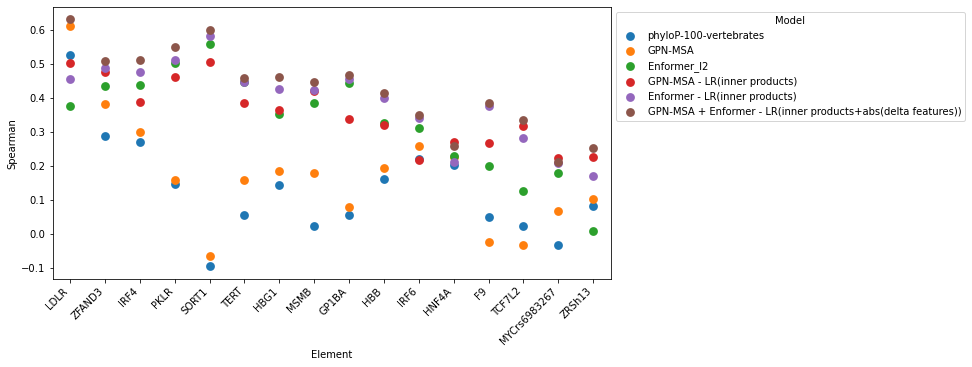

In [15]:
metric = "Spearman"
#metric = "Pearson"

plt.figure(figsize=(10, 5))
g = sns.pointplot(
    data=results,
    #data=results.replace({"GPN-MSA": "GPN-MSA (LLR)"}),
    #data=results[~results.Model.str.contains("best") & ~results.Model.str.contains("full")],
    #data=results[results.Model.str.contains("GPN-MSA")],
    hue="Model",
    x="Element",
    y=metric,
    join=False,
    order=results.groupby("Element")[metric].mean().sort_values(ascending=False).index.values,
);
plt.xticks(rotation=45, ha="right");
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));